In [1]:
from GVAE import smilesGVAE
from dataTools import s2oh

import pandas as pd
import numpy as np

Using TensorFlow backend.


# Calculate SLogP based on 56-D Hidden Rep

In [2]:
# for data 2000 cmpds from ZincDB
fn1 = 'data/zinc2k.csv'
df1 = pd.read_csv(fn1, sep='\t',index_col=0)

df1.head()

,Molecule
0,O=C(Cn1nc(ccc1=O)-c1cccc2ccccc12)NC1CCCCCC1
1,COc1cc(cc(OC)c1OC)C(=O)NCCn1c(C)nc2ncccc2c1=O
2,Fc1cc(F)c(CC(=O)NCCCc2nnc3ccccn23)cc1F
3,Cc1nc2ccc(F)cc2c(=O)n1CC(=O)Nc1nc(cs1)-c1cccnc1
4,Clc1cccc(c1)N1CCN(CC1)C(=O)CCC(=O)NCc1cccnc1


### Convert to One-hot encodings of grammar production rules.

In [3]:
smiles1 = list(df1['Molecule'])

In [4]:
soh1 = s2oh(smiles1)

### Use default network architechture with weights on 5M ZincDB cmpds  *Note: training data itself too big for github*

In [7]:
wf = 'data/5000k6MZinc_L56_E60_val.hdf5'

In [8]:
#Network parameters

params  = {
        'LATENT':56,
        'nC':3,
        'nD':3,
        'beta':1.0,
        'gruf':501,
        'ngpu':1,
        'opt':'adam',
        'wFile':wf
    }

In [9]:
sgv = smilesGVAE(**params)

### Get the 56-D Hidden Rep

In [10]:
H1 = sgv.emv.predict(soh1)[0]
np.shape(H1)

(2000, 56)

In [11]:
H1 = pd.DataFrame(H1,columns=['H'+str(i) for i in range(56)])
H1.head()

,H0,H1,H2,H3,H4,H5,H6,H7,H8,H9,...,H46,H47,H48,H49,H50,H51,H52,H53,H54,H55
0,-0.056452,-0.048531,-0.150616,-0.093743,0.067024,-0.020457,0.192012,-0.026030,0.167727,0.048220,...,0.249193,0.092645,-0.089358,-0.054265,0.063203,-0.091157,0.076444,0.148729,0.025671,-0.072653
1,0.207599,0.090353,-0.284250,0.223203,-0.177065,-0.054485,0.167771,0.025156,0.024902,-0.114339,...,0.371571,0.098776,-0.150744,0.079663,0.065034,-0.097502,0.006446,0.025683,-0.026152,0.118370
2,-0.013880,-0.035068,-0.259615,0.238261,-0.022644,-0.130764,0.107852,-0.065243,0.042585,-0.071855,...,0.204976,-0.016361,0.001261,-0.079490,-0.259187,-0.089213,-0.072343,-0.078527,0.241991,-0.101353
3,0.040539,-0.082396,-0.221651,0.035389,-0.066090,-0.024173,0.462721,-0.035353,0.091070,-0.183925,...,0.235006,-0.035177,0.113895,-0.074150,0.066039,-0.068341,-0.072201,-0.106540,-0.116148,0.281224
4,0.046550,0.024660,-0.023576,0.065885,0.083299,-0.234295,0.199290,0.064539,0.112091,-0.012676,...,-0.013561,-0.066350,-0.133875,-0.165434,0.058270,-0.077580,-0.053577,-0.102798,-0.172305,0.277824


### Calculate SLogP using RDKit

In [12]:
from rdkit import Chem
from rdkit.Chem import Descriptors

In [13]:
def slogp(s):
    m = Chem.MolFromSmiles(s)
    slp = Descriptors.MolLogP(m)
    return slp

In [14]:
slogp('OC1CCCCC1') # cyclohexanol

1.3114

In [15]:
vlogp = np.vectorize(slogp)

In [16]:
SLP = vlogp(smiles1)

In [17]:
SLP = pd.DataFrame(SLP,columns=['SLogP'])
SLP.head()

,SLogP
0,3.90250
1,1.55572
2,2.43810
3,3.00122
4,2.48020


In [18]:
def zvFilter(df):
    cvar = np.var(df,axis=0)
    idx=np.where(cvar==0.0)
    idx=list(df.columns[idx])
    return df.drop(columns=idx)

In [19]:
H1v = zvFilter(H1); H1v.head()

,H0,H1,H2,H3,H4,H5,H6,H7,H8,H9,...,H46,H47,H48,H49,H50,H51,H52,H53,H54,H55
0,-0.056452,-0.048531,-0.150616,-0.093743,0.067024,-0.020457,0.192012,-0.026030,0.167727,0.048220,...,0.249193,0.092645,-0.089358,-0.054265,0.063203,-0.091157,0.076444,0.148729,0.025671,-0.072653
1,0.207599,0.090353,-0.284250,0.223203,-0.177065,-0.054485,0.167771,0.025156,0.024902,-0.114339,...,0.371571,0.098776,-0.150744,0.079663,0.065034,-0.097502,0.006446,0.025683,-0.026152,0.118370
2,-0.013880,-0.035068,-0.259615,0.238261,-0.022644,-0.130764,0.107852,-0.065243,0.042585,-0.071855,...,0.204976,-0.016361,0.001261,-0.079490,-0.259187,-0.089213,-0.072343,-0.078527,0.241991,-0.101353
3,0.040539,-0.082396,-0.221651,0.035389,-0.066090,-0.024173,0.462721,-0.035353,0.091070,-0.183925,...,0.235006,-0.035177,0.113895,-0.074150,0.066039,-0.068341,-0.072201,-0.106540,-0.116148,0.281224
4,0.046550,0.024660,-0.023576,0.065885,0.083299,-0.234295,0.199290,0.064539,0.112091,-0.012676,...,-0.013561,-0.066350,-0.133875,-0.165434,0.058270,-0.077580,-0.053577,-0.102798,-0.172305,0.277824


In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
regr = RandomForestRegressor(n_estimators=100,oob_score=True)

In [22]:
regr.fit(H1v,SLP['SLogP'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [23]:
yob = regr.oob_prediction_
y = SLP['SLogP']

In [24]:
import seaborn as sbn
import matplotlib.pyplot as plt

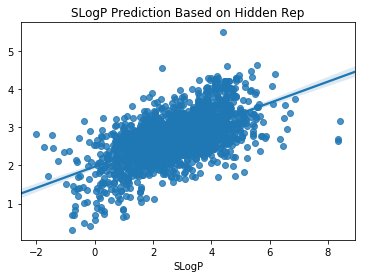

In [25]:
sbn.regplot(y,yob)
plt.title('SLogP Prediction Based on Hidden Rep')
plt.show()

In [26]:
from scipy.stats import pearsonr
r2, _P = pearsonr(y,yob)
print(f'R2 = {r2}')

R2 = 0.6066527136558725


In [27]:
from rdkit.Chem.rdmolops import PatternFingerprint

In [28]:
def fngrPrint(s):
    m = Chem.MolFromSmiles(s)
    f = PatternFingerprint(m)
    f = f.ToBitString()
    f = np.array([int(x) for x in f])
    f = f.reshape(1,-1)
    return f

In [29]:
fps = np.concatenate([fngrPrint(s) for s in df1.Molecule],axis=0)

In [30]:
cn = ['F'+str(i) for i in range(2048)]

In [31]:
fps = pd.DataFrame(fps,columns=cn); fps.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F2038,F2039,F2040,F2041,F2042,F2043,F2044,F2045,F2046,F2047
0,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
1,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
4,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


In [32]:
fpsv = zvFilter(fps); fpsv.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F2038,F2039,F2040,F2041,F2042,F2043,F2044,F2045,F2046,F2047
0,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
1,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
4,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


In [33]:
regr.fit(fpsv,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [34]:
yob = regr.oob_prediction_

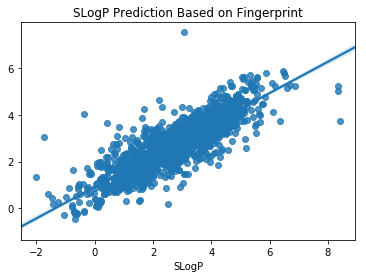

In [35]:
sbn.regplot(y,yob)
plt.title('SLogP Prediction Based on Fingerprint')
plt.show()

In [36]:
r2, _P = pearsonr(y,yob)
print(f'R2 = {r2}')

R2 = 0.8508406058711927


## Calculate Molecular Similarity based on Hidden Rep

In [5]:
#for similarity 200 pairs with Patern FP TS 
fn2 = 'data/Zinc2000Pairs.csv' 
df2 = pd.read_csv(fn2,sep='\t')
df2.head()

,Cmpd1,Cmpd2,TS
0,Brc1cc(co1)C(=O)N1CC=C(C1)c1ccccc1,Brc1cc(co1)C(=O)N1CC=C(C1)c1ccccc1,1.000000
1,COc1ccc(cc1)S(=O)(=O)NCc1ccc(cc1)C(=O)Nc1cccc2...,CC(=O)Nc1ccc(cc1)S(=O)(=O)N1CCC(CC1)C(=O)Nc1cc...,0.890591
2,Cc1cc(N)nc(SC[C@H]2Cn3c(S2)nnc3-c2cccnc2)n1,C(Sc1ccccc1)[C@H]1Cn2c(S1)nnc2-c1cccnc1,0.864322
3,CC[C@@H](Oc1cccc(C)c1)C(=O)NCc1ccc(OC2CC[NH+](...,[O-]C(=O)[C@@H](Cc1ccccc1)NC(=O)c1cccc(OCc2ccc...,0.851515
4,Fc1cc(ccc1C(=O)N1CCCC1)S(=O)(=O)N(CC#C)CC#C,CC[C@H]1CC[C@H](C)N1C(=O)c1cccc([N-]S(=O)(=O)c...,0.842893


In [6]:
cmpd1 = list(df2['Cmpd1'])
cmpd2 = list(df2['Cmpd2'])

In [38]:
ch1 = sgv.encode(cmpd1)

In [39]:
ch2 = sgv.encode(cmpd2)

In [97]:
def acsim(a,b):
    d = np.sqrt(np.dot(a,a)*np.dot(b,b))
    dst = np.dot(a,b) / d
    dst = np.arccos(dst)/np.pi
    return 1.0 - dst          

In [98]:
hsim = [acsim(a,b) for a,b in zip(ch1,ch2)]

In [100]:
df2['HSIM'] = hsim; df2.head()

,Cmpd1,Cmpd2,TS,HSIM
0,Brc1cc(co1)C(=O)N1CC=C(C1)c1ccccc1,Brc1cc(co1)C(=O)N1CC=C(C1)c1ccccc1,1.000000,1.000000
1,COc1ccc(cc1)S(=O)(=O)NCc1ccc(cc1)C(=O)Nc1cccc2...,CC(=O)Nc1ccc(cc1)S(=O)(=O)N1CCC(CC1)C(=O)Nc1cc...,0.890591,0.698287
2,Cc1cc(N)nc(SC[C@H]2Cn3c(S2)nnc3-c2cccnc2)n1,C(Sc1ccccc1)[C@H]1Cn2c(S1)nnc2-c1cccnc1,0.864322,0.562305
3,CC[C@@H](Oc1cccc(C)c1)C(=O)NCc1ccc(OC2CC[NH+](...,[O-]C(=O)[C@@H](Cc1ccccc1)NC(=O)c1cccc(OCc2ccc...,0.851515,0.515816
4,Fc1cc(ccc1C(=O)N1CCCC1)S(=O)(=O)N(CC#C)CC#C,CC[C@H]1CC[C@H](C)N1C(=O)c1cccc([N-]S(=O)(=O)c...,0.842893,0.449018


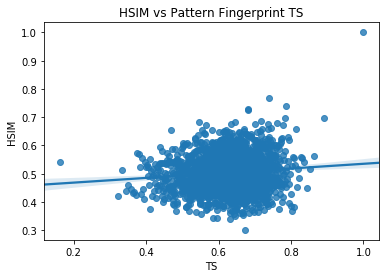

In [102]:
sbn.regplot(df2.TS,df2.HSIM)
plt.title('HSIM vs Pattern Fingerprint TS')
plt.show()